
На основе материалов <a href="https://matheusfacure.github.io/python-causality-handbook/landing-page.html">учебника</a>.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

np.random.seed(123)
sns.set(font_scale=1.3, palette='Set2')

## Conditional Average Treatment Effect (CATE)

Условный средний причинно-следственный эффект (CATE) для объекта $x$ для *бинарного тритмента*

$$\tau(x) = \mathsf{E}\left(С_1 - С_0\ | \ X=x\right),$$
где $C_0$ и $C_1$ &mdash; потенциальные исходы.

Формула определяет средний эффект от воздействия *на конкретный объект*. Оценка этой величины позволяет ответить на более сложный вопрос: на какие объекты стоит воздействовать? Например, одни клиенты могут положительно относиться к взаимодействию с ними, другие &mdash; отрицательно, а некоторым из них взаимодействие будет безразлично. Тогда такое взаимодействие стоит производить с первым типом клиентов, и по возможности не трогать второй тип.

Величина CATE имеет и другие названия:
* *эластичность* &mdash; понятие, пришедшее в основном из экономики;
* *uplift* &mdash; понятие, чаще используемое в data science аналитике.

Если *тритмент вещественный*, то CATE можно определить как
$$\tau(x) = \mathsf{E}\left(\left. \frac{dC_t}{dt}\ \right| \ X=x\right),$$
где $C_t$ &mdash; потенциальный исход при воздействии $t$. Отметим, что в таком случае мы имеем континуальное множество потенциальных исходов, из которых наблюдаемым может быть только один из них.

---

Рассмотрим данные по продажам мороженного:
* `temp` &mdash; температура воздуха;
* `weekday` &mdash; день недели;
* `cost` &mdash; стоимость, затраченная на приготовление;
* `price` &mdash; цена;
* `sales` &mdash; количество продаж.

Будем считать для простоты, что воздействие на цену рандомизировано.

In [2]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
print(prices_rnd.shape)
prices_rnd.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


Разделим на трейн и тест

In [3]:
train, test = train_test_split(prices_rnd)

Рассмотрим линейную модель прогнозирования эластичности. Для этого сначала построим линейную модель прогнозирования цены
$$sales = \theta_0 + \theta_1 {price} + \theta_2^Tx$$

В общем случае формула имеет вид
$$y = \theta_0 + \theta_1 t + \theta_2^Tx $$

In [4]:
m1 = smf.ols("sales ~ price + temp+C(weekday)+cost", data=train).fit()
m1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,186.7113,1.770,105.499,0.000,183.241,190.181
C(weekday)[T.2],-25.0512,0.924,-27.114,0.000,-26.863,-23.240
C(weekday)[T.3],-24.5834,0.901,-27.282,0.000,-26.350,-22.817
C(weekday)[T.4],-24.3807,0.897,-27.195,0.000,-26.138,-22.623
C(weekday)[T.5],-24.9036,0.894,-27.850,0.000,-26.657,-23.150
C(weekday)[T.6],-24.0921,0.903,-26.693,0.000,-25.862,-22.323
C(weekday)[T.7],-0.8635,0.888,-0.972,0.331,-2.605,0.878
price,-2.7515,0.106,-25.970,0.000,-2.959,-2.544
temp,1.9848,0.060,33.117,0.000,1.867,2.102
cost,4.4718,0.528,8.462,0.000,3.436,5.508


Для этой модели, прогноз эластичности цены равен
$$\widehat{\dfrac{d y}{d t}} = \widehat{\theta}_1 = -2.75.$$

Здесь мы предсказываем одинаковую эластичность для всех объектов, и мы не можем понять, в какие дни люди менее чувствительны к ценам на мороженое. По сути он оценивает ATE, хотя нам нужен был CATE. 

Рассмотрим другую модель
$$sales = \theta_0 + \theta_1 {price} + \theta_2 {price} \cdot {temp} + \theta_3^T X$$

или в общем случае
$$y = \theta_0 + \theta_1 t + \theta_2^T (X \cdot t) + \theta_3^T X$$

Эта модель включает в себя **взаимодействие** между ценой и температурой. Тем самым она позволяет эластичности отличаться при разных температурах.

In [5]:
m2 = smf.ols("sales ~ price*temp + C(weekday) + cost", data=train).fit()
m2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.4767,4.371,44.037,0.000,183.907,201.046
C(weekday)[T.2],-25.0805,0.924,-27.143,0.000,-26.892,-23.269
C(weekday)[T.3],-24.5871,0.901,-27.290,0.000,-26.354,-22.821
C(weekday)[T.4],-24.4225,0.897,-27.231,0.000,-26.181,-22.664
C(weekday)[T.5],-24.8953,0.894,-27.844,0.000,-26.648,-23.142
C(weekday)[T.6],-24.1269,0.903,-26.726,0.000,-25.897,-22.357
C(weekday)[T.7],-0.8581,0.888,-0.966,0.334,-2.599,0.883
price,-3.6299,0.618,-5.873,0.000,-4.842,-2.418
temp,1.7459,0.176,9.912,0.000,1.401,2.091
price:temp,0.0366,0.025,1.443,0.149,-0.013,0.086


Для этой модели эластичность определяется как
$$\widehat{\frac{d y}{d t}} = \widehat{\theta}_1 + \widehat{\theta}_2^T X = -3.630 + 0.037 X$$

Тем самым в среднем, когда мы повышаем цену, продажи снижаются. Но при повышением температуры люди становятся чуть менее чувствительными к повышению цен на мороженое.

---

Можем также взять все остальные признаки

$$sales = \theta_0 + \theta_1 price + \theta_2^T (X \cdot price) + \theta_3^T X $$

In [6]:
m3 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()
m3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,245.5934,3.426,71.684,0.000,238.876,252.310
C(weekday)[T.2],-90.1681,1.969,-45.804,0.000,-94.028,-86.309
C(weekday)[T.3],-89.9918,1.923,-46.788,0.000,-93.763,-86.221
C(weekday)[T.4],-92.8179,1.968,-47.164,0.000,-96.676,-88.959
C(weekday)[T.5],-89.8630,1.920,-46.799,0.000,-93.628,-86.098
C(weekday)[T.6],-94.3701,1.921,-49.125,0.000,-98.136,-90.604
C(weekday)[T.7],-0.6167,1.913,-0.322,0.747,-4.368,3.134
price,-11.2623,0.489,-23.036,0.000,-12.221,-10.304
price:C(weekday)[T.2],9.8965,0.286,34.623,0.000,9.336,10.457
price:C(weekday)[T.3],9.8761,0.276,35.821,0.000,9.336,10.417


---

В общем случае прогнозы эластичности  можно получить с помощью приближения производной

$$\widehat{\frac{d y}{d t}} = \dfrac{\widehat{y}(t+\varepsilon) - \widehat{y}(t)}{ (t + \varepsilon) - t }$$

В частности, при $\varepsilon = 1$ получаем
$$\widehat{\frac{d y}{d t}} = \widehat{y}(t+1) - \widehat{y}(t)$$

In [7]:
def predict_elasticity(model, df, t="price", h=1):
    return (model.predict(df.assign(**{t:df[t]+h})) - model.predict(df)) / h

Получим предсказания эластичности для двух моделей

In [8]:
test.assign(pred_elast=predict_elasticity(m1, test)).head()

,temp,weekday,cost,price,sales,pred_elast
2648,18.6,7,0.5,10,185,-2.751463
2456,26.0,3,0.5,10,200,-2.751463
4557,23.7,3,0.3,8,192,-2.751463
4884,28.9,4,1.5,6,213,-2.751463
92,23.7,1,0.5,8,207,-2.751463


In [9]:
test.assign(pred_elast=predict_elasticity(m3, test)).head()

,temp,weekday,cost,price,sales,pred_elast
2648,18.6,7,0.5,10,185,-10.301045
2456,26.0,3,0.5,10,200,0.036165
4557,23.7,3,0.3,8,192,-0.132057
4884,28.9,4,1.5,6,213,0.860663
92,23.7,1,0.5,8,207,-9.953698


В правой колонке мы получили предсказания того, насколько изменились бы продажи при повышении цены на 1 у.е. в данный конкретный день.

---

Попробуем также бустинг

In [10]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

gb_model = GradientBoostingRegressor()
gb_model.fit(train[X], train[y]);

In [11]:
test.assign(pred_elast=predict_elasticity(gb_model, test[X])).head()

,temp,weekday,cost,price,sales,pred_elast
2648,18.6,7,0.5,10,185,0.000000
2456,26.0,3,0.5,10,200,0.000000
4557,23.7,3,0.3,8,192,2.724037
4884,28.9,4,1.5,6,213,0.498149
92,23.7,1,0.5,8,207,-12.441746


## Оценка качества моделей

В традиционном ML у нас есть все значения тестовой выборки, и мы легко можем посчитать ошибку/качество модели. Но в causal inference мы можем наблюдать только один потенциальный исход. В то время как для непрерывного тритмента (например, цены) таких потенциальных исходов континуум.

Рассмотрим два набора данных по продажам мороженного &mdash; со случайным назначением цены и с неслучайным.

In [16]:
prices = pd.read_csv("./data/ice_cream_sales.csv")
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")

print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


Обучим две модели &mdash; линейная регрессия и градиентный бустинг

In [17]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

In [18]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

Посчитаем эластичность каждой модели, а также добавим рандомную эластичность (т.е. случайные предсказания)

In [19]:
prices_rnd_pred = prices_rnd.assign(**{
    "elast_m_pred": predict_elasticity(m1, prices_rnd),
    "pred_m_pred": predict_elasticity(m2, prices_rnd[X], h=0.5),
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]),
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,elast_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,-12.174470,0.547866
1,22.7,3,0.5,4,190,1.054695,-3.457289,0.445907
2,33.7,7,1.0,5,237,-17.362642,-7.407668,0.174312
3,23.0,4,0.5,5,193,0.564985,-2.045721,0.070963
4,24.4,1,1.0,3,252,-13.717946,-1.408868,0.481439


Для лучшего понимания сначала рассмотрим бинарный тритмент. Например, может предоставляться скидка на мороженное, соответственно, цены могут быть либо высокими, либо низкими. 

Построим график, где будут
* продажи по оси Y, 
* прогнозы моделей по оси X, 
* а цена соответствует по цвету. 

Разделим данные по оси модели на три группы одинакового размера. Если тритмент назначался случайно, то можем оценить ATE для каждой группы и построить зависимость от номера группы в виде bar plot (вторая линия графиков).

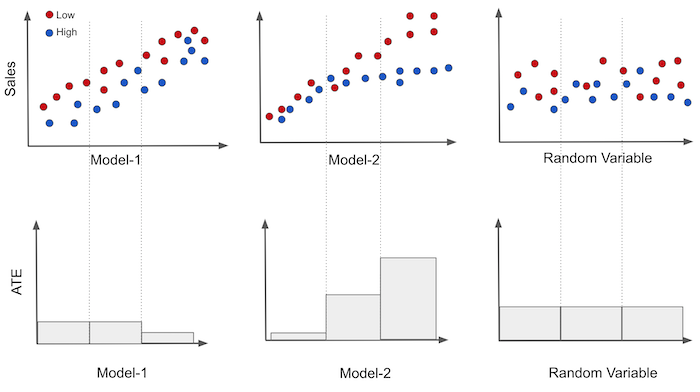

Отсортируем полученные группы по степени чувствительности (первая линия ниже). Тем самым мы получим, что в первой группе по мнению модели сильнее всего реагируют на изменение цены.

Далее можем построить кривую кумулятивной эластичности. Сначала оценим эластичность первой группы, затем первой и второй и так далее, пока не возьмем все группы сразу. В конце мы оцениваем эффект для всего набора данных.

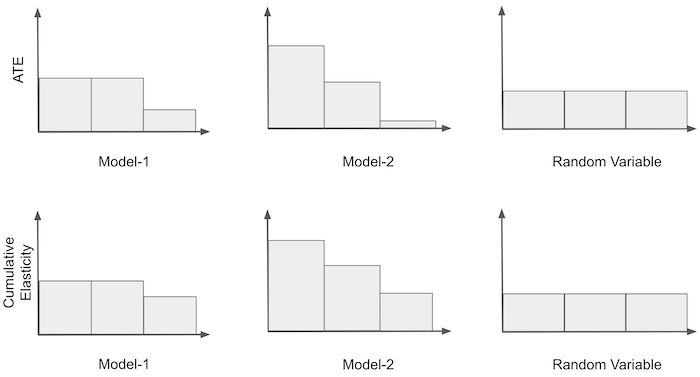

Теперь домножим все точки в построенной кривуой кумулятивной эластичности на долю выборки, для которой оценена эластичность в точке. Например, если совокупная эластичность на 30% составляет -0.5 то мы получаем $-0.5 \cdot 0.3 = -0.15$

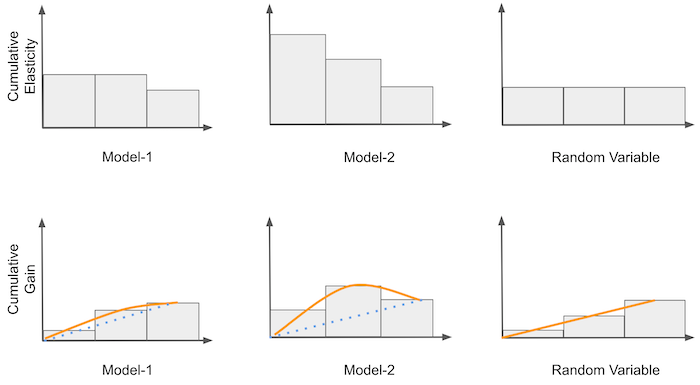

Теперь понятно, как обобщить этот процесс. 
1. Отсортировать предсказания модели по убыванию, тем самым сначала будут объекты с положительным эффектом от тритмента. 
2. Поделить данные на бины.
3. Оценить ATE простой линейной моделью по бинам кумулятивно, то есть сначала ATE по бину 1, затем ATE по объединению бинов 1 и 2, по объединению 1, 2 и 3, и т.д.
4. Домножить полученные значения на долю объектов, по которым считалась эластичность.

Реализуем данный процесс

In [20]:
def elast(data, y, t):
    ''' Эластичность как коэффициент в линейной регрессии. '''
    
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))


def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    ''' Кривая кумулятивной эластичности. '''
    
    size = dataset.shape[0]
    
    # Сортировка по предсказанию
    ordered_df = dataset.sort_values(prediction, ascending=False)
    ordered_df = ordered_df.reset_index(drop=True)
    
    # Определение количества бинов
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([
        # Вычисление эластичности и домножение на долю объектов
        elast(ordered_df.head(rows), y, t) * (rows/size) 
        for rows in n_rows
    ])

Построим кривые для наших моделей

<ipython-input-20-52e76faa48a9>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


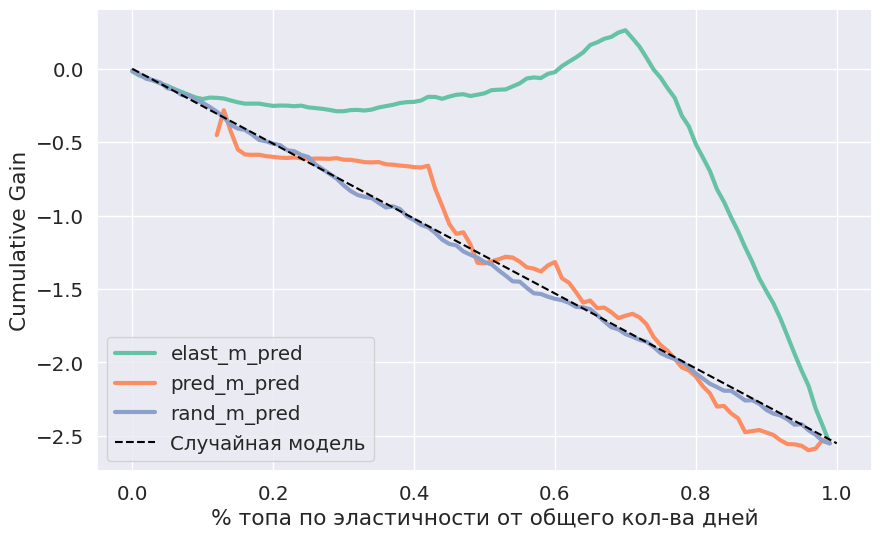

In [21]:
plt.figure(figsize=(10, 6))

for model_name in ["elast_m_pred", "pred_m_pred", "rand_m_pred"]:
    cum_gain = cumulative_gain(
        prices_rnd_pred, model_name, 
        "sales", "price", 
        min_periods=50, steps=100
    )
    x = np.array(range(len(cum_gain))) / len(cum_gain)
    plt.plot(x, cum_gain, label=model_name, lw=3)
    
plt.plot(
    [0, 1], 
    [0, elast(prices_rnd_pred, "sales", "price")], 
    linestyle="--", 
    label="Случайная модель", 
    color="black"
)

plt.xlabel("% топа по эластичности от общего кол-ва дней")
plt.ylabel("Cumulative Gain")
plt.legend()
plt.show();

Видим, что линейная модель (зеленая) оказалась лучше, потому как она проходит выше всего. Рандомная модель практически совпадает со случайной моделью. Она должна давать константу, поскольку в силу случайности бины должны быть статистически идентичны, а значит и оценка ATE должна совпадать. Наклон получается за счет домножения на долю объектов. Кроме того, можно заметить, что все кривые сходятся в точку, которая соответствует ATE по всему набору данных.